In [1]:
import numpy as np
import pandas as pd

from collections import Counter
from math import sqrt
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score as r2

import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

### 1. Dataset Overview

In [2]:
# import dataset and 2 other files that will help us preprocess the dataset
dataset = pd.DataFrame(pd.read_csv("speeddating.csv", low_memory=False))

to_encode = np.array(pd.read_csv('to_encode.csv')).squeeze()
to_interpolate = np.array(pd.read_csv('to_interpolate.csv')).squeeze()

In [3]:
dataset.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,...,[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1


In [4]:
print('The dataset containes {} rows described by {} attributes.'.format(dataset.shape[0], dataset.shape[1]))

The dataset containes 8378 rows described by 123 attributes.


In [5]:
print(dataset.dtypes[:10])

has_null     int64
wave         int64
gender      object
age         object
age_o       object
d_age        int64
d_d_age     object
race        object
race_o      object
samerace     int64
dtype: object


### Dataset Preprocessing

In [6]:
# method to handle missing_values
def interpolate_missing_values(df_col, method='pad'):
        dataset[df_col].interpolate(method, inplace=True)
        dataset[df_col] = dataset[df_col].astype(np.float)

In [7]:
# method to encode the categorical features
def simple_encoder(col_name):
    simple_encoder = LabelEncoder()
    
    if dataset[col_name].isnull().values.any():
        dataset[col_name][dataset[col_name].isnull() == False] = simple_encoder.fit_transform(dataset[col_name][dataset[col_name].isnull() == False])
    else:
        dataset[col_name] = simple_encoder.fit_transform(dataset[col_name])
        
    return simple_encoder.classes_

In [8]:
# missing values are marked as '?' in this dataset so first we need to
# convert them to NaN, to be more 'visible'
dataset.replace('?', np.nan, inplace=True)

In [9]:
# extract the column named 'match' which is our target
labels = dataset.match

print("Missing Values in Target: ", labels.isnull().values.any())
print("Check Balance:\nClass 0 - {}\nClass 1 - {}".format(Counter(labels)[0], Counter(labels)[1]))

Missing Values in Target:  False
Check Balance:
Class 0 - 6998
Class 1 - 1380


In [10]:
# drop columns 'decision' and 'decision_o' (as said in the paper)
dataset.drop(['match', 'decision', 'decision_o'], axis=1, inplace=True)

In [11]:
# encode categorical features
cls = []

for el in to_encode:
    if el in ['race', 'gender']:
        cls.append(simple_encoder(el))
    else:
        simple_encoder(el)

/home/marina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# interpolate missing values
for el in to_interpolate:
    interpolate_missing_values(el)

In [13]:
# overview after preprocessing
print('Shape: {} - same number of rows'.format(dataset.shape))
print('Check dtypes of columns to make sure they are now numerical features:\n', Counter(dataset.dtypes))
print('Missing values: ', dataset.isnull().values.any())
dataset.head()

Shape: (8378, 120) - same number of rows
Check dtypes of columns to make sure they are now numerical features:
 Counter({dtype('int64'): 60, dtype('float64'): 60})
Missing values:  False


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0,1,0,21.0,27.0,6,2,0.0,3.0,0,...,2.0,4.0,0,0,1,7.0,6.0,1,1,0.0
1,0,1,0,21.0,22.0,1,0,0.0,3.0,0,...,2.0,4.0,0,0,1,7.0,5.0,1,1,1.0
2,1,1,0,21.0,22.0,1,0,0.0,0.0,1,...,2.0,4.0,0,0,1,7.0,5.0,1,0,1.0
3,0,1,0,21.0,23.0,2,1,0.0,3.0,0,...,2.0,4.0,0,0,1,7.0,6.0,1,1,0.0
4,0,1,0,21.0,24.0,3,1,0.0,2.0,0,...,2.0,4.0,0,0,1,6.0,6.0,1,1,0.0


### 3. Advanced Dataset Overview

In [14]:
cls[1][0:3] = [cls[1][i].partition('/')[0][1:] for i in range(3)]
cls[1][3:5] = [cls[1][i].partition('/')[0] for i in range(3, 5)]
cls[1]

array(['Asian', 'Black', 'Latino', 'European', 'Other'], dtype=object)

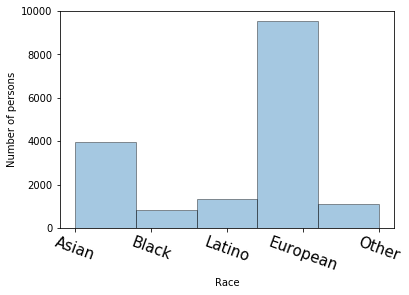

In [15]:
# Race Distribution
sns.distplot(dataset.race.append(dataset.race_o), bins=5, kde=False,
            hist_kws={'edgecolor':'black'}, axlabel='Race')
plt.ylabel('Number of persons')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=cls[1], rotation=-20, size=15)

plt.show()

[24. 28.]


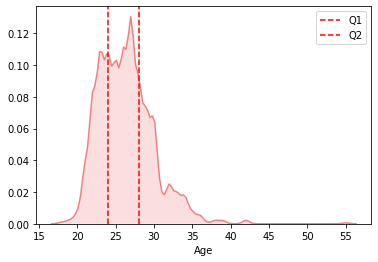

In [16]:
# Age Distribution
sns.kdeplot(dataset.age.append(dataset.age_o), shade=True, color='lightcoral')

plt.xlabel('Age')
xposition = np.percentile(dataset.age.append(dataset.age_o), [25, 75])
print(xposition)
for idx, xc in enumerate(xposition):
    plt.axvline(x=xc, color='r', linestyle='--', label='Q{}'.format(idx+1))
    
plt.legend()
plt.show()


In [17]:
cls[0] = [cls[0][i] + ': ' + str(Counter(dataset.gender)[i]) for i in range(2)]
cls[0]

['female: 4184', 'male: 4194']

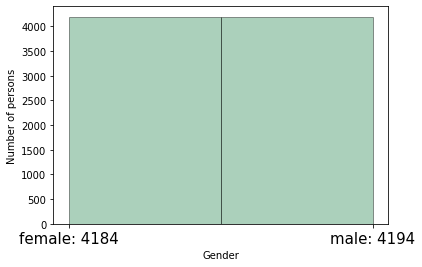

In [18]:
# Gender Distribution
sns.distplot(dataset.gender, bins=2, kde=False, hist_kws={'edgecolor':'black'}, axlabel='Gender', color='seagreen')
plt.xticks(ticks=[0, 1], labels=cls[0], size=15)
plt.ylabel('Number of persons')

plt.show()

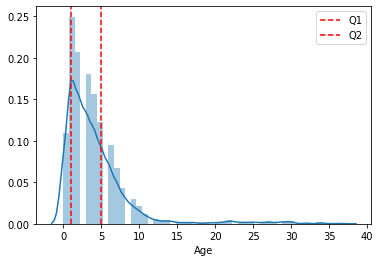

In [19]:
# Age Differance
sns.distplot(dataset.d_age)

plt.xlabel('Age')
xposition = np.percentile(dataset.d_age, [25, 75])

for idx, xc in enumerate(xposition):
    plt.axvline(x=xc, color='r', linestyle='--', label='Q{}'.format(idx+1))

plt.legend()
plt.show()

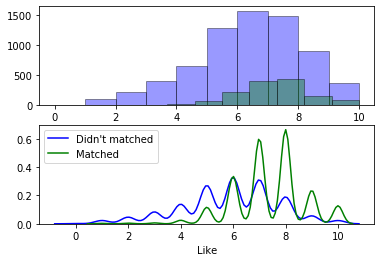

In [20]:
# How much likeness influnce decision
fig, ax =plt.subplots(2,1)
sns.distplot(dataset.like[labels ==0 ], bins=10, kde=False,
             hist_kws={'edgecolor':'black', 'color':'b'}, 
             axlabel='Like', label='Didn\'t matched', ax=ax[0])
sns.distplot(dataset.like[labels ==1 ], bins=10, kde=False,
             hist_kws={'edgecolor':'black', 'color':'g'}, 
             axlabel='Like', label='Matched', ax=ax[0])

sns.distplot(dataset.like[labels ==0 ], bins=10, hist=False,
             kde_kws={ 'color':'b'}, axlabel='Like', label='Didn\'t matched', ax=ax[1])
sns.distplot(dataset.like[labels ==1 ], bins=10, hist=False,
             kde_kws={'color':'g'}, axlabel='Like', label='Matched', ax=ax[1])
plt.legend()
plt.show()


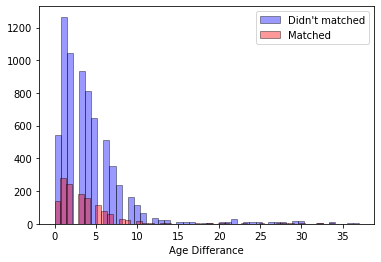

In [21]:
# How age differance influence decision
sns.distplot(dataset.d_age[labels ==0 ],  kde=False,
             hist_kws={'edgecolor':'black', 'color':'b'}, 
             axlabel='Like', label='Didn\'t matched')
sns.distplot(dataset.d_age[labels ==1 ],  kde=False,
             hist_kws={'edgecolor':'black', 'color':'r'}, 
             axlabel='Age Differance', label='Matched')
plt.legend()
plt.show()

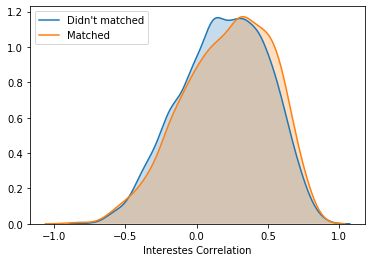

In [22]:
# How the correlation between interest influences decision
no_match = dataset.interests_correlate[labels ==0 ]
match = dataset.interests_correlate[labels ==1 ]

sns.kdeplot(no_match, shade=True, label='Didn\'t matched')
sns.kdeplot(match, shade=True, label='Matched')
plt.xlabel(xlabel='Interestes Correlation')
plt.legend()
plt.show()

### 4. Feature Selection Methods 

#### 4.1. Forward Stepwise Selection 

In [23]:
def train_subset(feature_set=None, ds=None, dataset_b=False):
    # fit model on feature_set and compute RSS and MAE
    if dataset_b:
        data = ds
    else:
#         print(dataset)
        data = dataset[list(feature_set)]
        
    model = OLS(labels, data).fit()
    # OLS comes from Ordinary Least Squares
    prediction = model.predict(data)
    rss = np.sum((prediction - labels) ** 2)
    mae_score = mae(labels, prediction)
    
    return {'model': model, 'RSS': rss, 'MAE': mae_score}

In [24]:
def forward(predictors):
    
    remaining_predictors = [p for p in dataset.columns if p not in predictors]
    results = []
    
    for predictor in remaining_predictors:
        results.append(train_subset(feature_set=predictors+[predictor]))
    
    models = pd.DataFrame(results)
    
    # choose the model with the lowest RSS
    best_model = models.loc[np.argmin(np.array(models.RSS))]
    
    print("Processed ", models.shape[0], "models on", len(predictors)+1, 'predictors')
    
    return best_model

In [25]:
# start from 0 predictors
predictors = []
models_fwd = pd.DataFrame(columns=["RSS", "model", 'MAE'])

for i in range(1,len(dataset.columns)+1):
    # choose best model with i predictors
    models_fwd.loc[i] = forward(predictors)
    # take the predictors from the previous model
    predictors = models_fwd.loc[i]["model"].model.exog_names


Processed  120 models on 1 predictors
Processed  119 models on 2 predictors
Processed  118 models on 3 predictors
Processed  117 models on 4 predictors
Processed  116 models on 5 predictors
Processed  115 models on 6 predictors
Processed  114 models on 7 predictors
Processed  113 models on 8 predictors
Processed  112 models on 9 predictors
Processed  111 models on 10 predictors
Processed  110 models on 11 predictors
Processed  109 models on 12 predictors
Processed  108 models on 13 predictors
Processed  107 models on 14 predictors
Processed  106 models on 15 predictors
Processed  105 models on 16 predictors
Processed  104 models on 17 predictors
Processed  103 models on 18 predictors
Processed  102 models on 19 predictors
Processed  101 models on 20 predictors
Processed  100 models on 21 predictors
Processed  99 models on 22 predictors
Processed  98 models on 23 predictors
Processed  97 models on 24 predictors
Processed  96 models on 25 predictors
Processed  95 models on 26 predictors


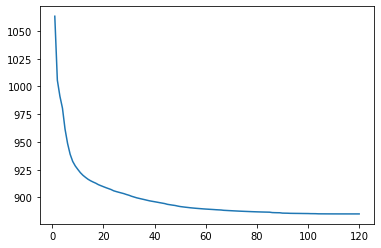

In [26]:
# results for this method
plt.plot(models_fwd.RSS)

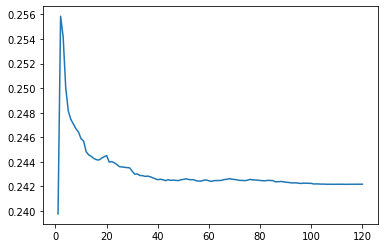

In [27]:
plt.plot(models_fwd.MAE)

In [28]:
print(np.argmin(np.array(models_fwd.RSS)))
print(np.argmin(np.array(models_fwd.MAE)))

119
0


#### 4.2. Backward Stepwise Selection

In [29]:
def backward(predictors):
    
    results = []
    
    for predictor in predictors:
        aux = list(predictors)
        aux.remove(predictor)
        results.append(train_subset(feature_set=aux))
    
    models = pd.DataFrame(results)
    
    # choose the model with the lowest RSS
    best_model = models.loc[np.argmin(np.array(models['RSS']))]

    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors")
    
    return best_model

In [30]:
models_bwd = pd.DataFrame(columns=["RSS", "model", "MAE"], index = range(1,len(dataset.columns)))
# start from all predictors
predictors = dataset.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names


Processed  120 models on 119 predictors
Processed  119 models on 118 predictors
Processed  118 models on 117 predictors
Processed  117 models on 116 predictors
Processed  116 models on 115 predictors
Processed  115 models on 114 predictors
Processed  114 models on 113 predictors
Processed  113 models on 112 predictors
Processed  112 models on 111 predictors
Processed  111 models on 110 predictors
Processed  110 models on 109 predictors
Processed  109 models on 108 predictors
Processed  108 models on 107 predictors
Processed  107 models on 106 predictors
Processed  106 models on 105 predictors
Processed  105 models on 104 predictors
Processed  104 models on 103 predictors
Processed  103 models on 102 predictors
Processed  102 models on 101 predictors
Processed  101 models on 100 predictors
Processed  100 models on 99 predictors
Processed  99 models on 98 predictors
Processed  98 models on 97 predictors
Processed  97 models on 96 predictors
Processed  96 models on 95 predictors
Processed

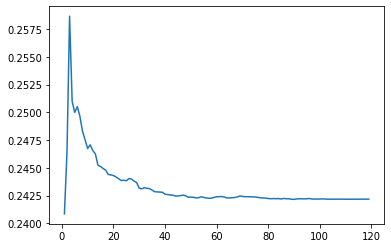

In [31]:
# results for this method
plt.plot(models_bwd.MAE)

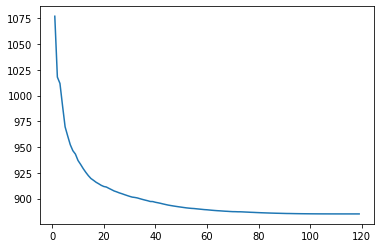

In [32]:
plt.plot(models_bwd.RSS)

In [33]:
print(np.argmin(np.array(models_bwd.RSS)))
print(np.argmin(np.array(models_bwd.MAE)))

118
0


#### 4.3. PCA

In [34]:
def apply_pca(num_comp, dataset):
    
    pca = PCA(n_components=num_comp)
    data = pca.fit_transform(dataset)
    
    return data

In [35]:
datasets_pca = [apply_pca(40, dataset), apply_pca(80, dataset), apply_pca(100, dataset), 
                apply_pca(110, dataset)]

In [36]:
models_pca = []
for ds in datasets_pca:
    models_pca.append(train_subset(ds=ds, dataset_b=True))
models_pca = pd.DataFrame(models_pca)

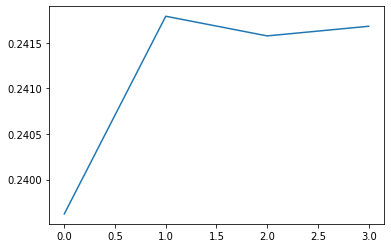

In [37]:
plt.plot(models_pca.MAE)

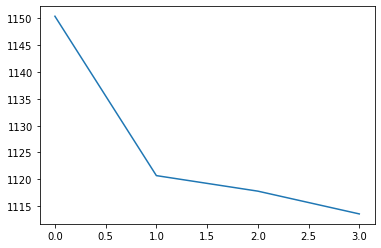

In [38]:
plt.plot(models_pca.RSS)

In [39]:
print(np.argmin(np.array(models_pca.RSS)))
print(np.argmin(np.array(models_pca.MAE)))

3
0


#### 4.4. Differances between methods


In [40]:
best_fwd = models_fwd[models_fwd.RSS == min(models_fwd.RSS)]
best_bwd = models_bwd[models_bwd.RSS == min(models_bwd.RSS)]
best_pca = models_pca[models_pca.RSS == min(models_pca.RSS)]

In [41]:
# tabel with results
x = PrettyTable(["Method", "RSS", "MAE"])
x.add_row(['Fwd', round(best_fwd.RSS.iloc[0], 4), round(best_fwd.MAE.iloc[0], 4)])
x.add_row(['Bwd', round(best_bwd.RSS.iloc[0], 4), round(best_bwd.MAE.iloc[0], 4)])
x.add_row(['PCA', round(best_pca.RSS.iloc[0], 4), round(best_pca.MAE.iloc[0], 4)])
print(x)

+--------+-----------+--------+
| Method |    RSS    |  MAE   |
+--------+-----------+--------+
|  Fwd   |  885.1488 | 0.2422 |
|  Bwd   |  885.1488 | 0.2422 |
|  PCA   | 1113.5297 | 0.2417 |
+--------+-----------+--------+


### 5. Train models

In [42]:
# print classification results
def show_results_fun(name, model, test_data, true_labels, prediction):
    acc = accuracy_score(true_labels, prediction)
    f1 = f1_score(true_labels, prediction)
    
    print('For model {} dataset, we got the following results:\nAccuracy: {}\nF1-score: {}\n'.format(name, acc, f1))
    plot_confusion_matrix(model, test_data, true_labels, cmap=plt.cm.Blues)

In [43]:
# function to train a classification model
def train_cls_model(dataset, labels, model, show_results=False, name=None):
    
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=21)

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    
    if show_results:
        show_results_fun(name, model, X_test, y_test, prediction)
    
    return (accuracy_score(y_test, prediction), f1_score(y_test, prediction))

In [44]:
# print regression results
def show_results_fun_reg(name, true_labels, prediction):
    mae_score = mae(true_labels, prediction)
    mse_score = mse(true_labels, prediction)
    r2_score = r2(true_labels, prediction)
    rmse = sqrt(mse(true_labels, prediction))
    
    print('For model {} dataset we got the following results:\nMAE: {}\nMSE: {}\nR2-score: {}\nRMSE: {}'.format(name, mae_score, mse_score, r2_score, rmse))


In [45]:
# function to train a regression model
def train_reg_model(dataset, labels, model, show_results=False, name=None):
    
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=21)

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    if show_results:
        show_results_fun_reg(name, y_test, prediction)
    
    return (mae(y_test, prediction), mse(y_test, prediction), r2(y_test, prediction),  sqrt(mse(y_test, prediction)))

### 6. Best Models

In [46]:
# selecting best datasets generated with each feature selection method
dataset_fwd = dataset[best_fwd.model.iloc[0].model.exog_names]
dataset_bwd = dataset[best_bwd.model.iloc[0].model.exog_names]
dataset_pca = datasets_pca[best_pca.index[0]]

In [47]:
# models 
models_cls = [LinearSVC(), RidgeClassifier(), KNeighborsClassifier(), RandomForestClassifier()]
models_reg = [Ridge(), LinearRegression()]

# parameters for gridsearch
parameters_cls = [{'C': [1, 0.1, 0.01, 0.001, 0.0001, 10, 100], 'max_iter': [2000, 3000, 1000], 'tol': [0.0001, 0.001]}, 
                  {'normalize': [True, False], 'alpha': [1, 0.9, 0.8, 0.7, 0.6]},
                  {'n_neighbors': [3, 5, 7, 9, 11, 21]},
                  {'n_estimators': [100, 200, 150, 170, 250]}]

parameters_reg = [{'normalize': [True, False], 'alpha': [1, 0.9, 0.8, 0.7, 0.6]}, 
                  {'normalize': [True, False]}]

# datasets
datasets = [dataset, dataset_fwd, dataset_bwd, dataset_pca]

# models names
models_names_cls = {0: 'Linear SVC', 
                    1: 'Ridge Classifier',
                    2: 'KNN',
                    3: 'Random Forest',}

models_names_reg = {0: 'Ridge Regression',
                    1: 'Linear Regression',}
# datasets names
datasets_names = {0: 'Initial', 
                  1: 'Forward Selection',
                  2: 'Backward Selection',
                  3: 'PCA',}

In [48]:
# Gridsearch
def best_models(datasets, labels, models, parameters):
    idx = -1
    best_models = []
    for model in models:
        idx += 1
        for dataset in datasets:
            clf = GridSearchCV(model, parameters[idx], verbose=2)
            clf.fit(dataset, labels)
            
            best_models.append(clf.best_estimator_)
    return best_models

In [49]:
# selecting best classifiers
best_cls = best_models(datasets, labels, models_cls, parameters_cls)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.5s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.5s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.0s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.1s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.3s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.4s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.5s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.4s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.7s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=   9.8s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.4s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.5s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.9s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.7s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.7s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.6s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.6s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=  10.0s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.1s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.7s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.5s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.2s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.1s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.3s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.1s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.7s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.2s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.7s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.7s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.6s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.7s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.8s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.5s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.8s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.8s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.6s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.7s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.6s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.8s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.5s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.2s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.7s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   9.3s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.4s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   9.3s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.5s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   7.9s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.4s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   7.9s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.0s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.0s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.1s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.8s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.9s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.8s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.2s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   4.2s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   2.9s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   4.5s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.1s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.1s
[CV] C=0.001, max_iter=3000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=3000, tol=0.0001, total=   4.2s
[CV] C=0.001, max_iter=3000, tol=0.0001 ..............................
[CV] .

/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.7s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.001 ..............................
[CV] ............... C=0.0001, max_iter=2000, tol=0.001, total=   0.4s
[CV] C=0.0001, max_iter=2000, tol=0.001 ..............................
[CV] .

/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.6s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.6s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.5s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.5s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=  10.6s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.5s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   9.5s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   9.4s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.5s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.6s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.5s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.3s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.9s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.8s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.4s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.2s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.0s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.9s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.7s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.4s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.3s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   9.9s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   9.5s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 18.0min finished


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.4s
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.1s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.1s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.6s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.7s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.2s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  10.8s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  10.4s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  10.2s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  10.3s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  11.9s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  11.0s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.2s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=   9.8s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=   9.5s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=   9.4s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.8s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.7s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.6s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   7.0s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.9s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.9s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   7.6s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   7.1s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.7s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.9s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.5s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   8.7s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.0s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   8.9s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   8.8s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.3s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   8.7s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.7s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   6.1s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   6.0s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.3s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.7s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.9s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   6.1s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   6.0s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.9s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.5s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.7s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.5s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.8s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.7s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.8s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.8s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.0s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.5s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.3s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.4s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.3s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.3s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   4.1s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.4s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.3s
[CV] C=0.001, max_iter=3000, tol=0.0001 ..............................
[CV] .

/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.8s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   3.0s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   3.0s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.6s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.6s
[CV] C=0.0001, max_iter=2000, tol=0.001 ..............................
[CV] ............... C=0.0001, max_iter=2000, tol=0.001, total=   0.4s
[CV] C=0.0001, max_iter=2000, tol=0.001 ..............................
[CV] .

/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.1s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.3s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.4s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=  10.1s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.9s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=  10.1s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.7s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   9.8s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.4s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   9.3s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.8s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   7.4s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   7.0s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.0s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.0s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.3s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.1s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.4s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.2s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.5s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.9s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.8s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 18.5min finished


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.9s
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.0s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   6.7s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.9s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.2s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.9s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.7s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.3s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   9.7s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=   9.6s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=   9.3s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.1s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.6s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   7.1s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.0s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.0s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.4s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.6s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   6.6s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=  10.1s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.8s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=  10.3s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   9.8s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=  10.3s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.8s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.9s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=  10.2s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   9.2s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   6.3s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.8s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.6s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.6s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.7s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.8s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   6.2s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.7s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   5.4s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   7.9s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   7.9s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.1s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   8.1s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   7.8s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   7.9s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   7.7s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   7.9s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.7s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   8.2s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.0s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   3.0s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.1s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.7s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.6s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   5.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.3s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   4.2s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   4.5s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.2s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   3.2s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   4.9s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] .

/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.8s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.7s
[CV] C=0.001, max_iter=1000, tol=0.0001 ..............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=0.001, max_iter=1000, tol=0.0001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=0.001, max_iter=1000, tol=0.001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.001, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.6s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.6s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.6s
[CV] C=0.0001, max_iter=2000, tol=0.0001 .............................
[CV] .............. C=0.0001, max_iter=2000, tol=0.0001, total=   0.5s
[CV] C=0.0001, max_iter=2000, tol=0.001 ..............................
[CV] ............... C=0.0001, max_iter=2000, tol=0.001, total=   0.4s
[CV] C=0.0001, max_iter=2000, tol=0.001 ..............................
[CV] .

/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   7.0s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   6.4s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.7s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.9s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   7.0s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   6.9s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=  10.2s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   8.9s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.8s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.4s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.2s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.4s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  10.4s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   9.7s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   7.1s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   7.0s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   7.6s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   7.0s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.9s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   7.1s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.7s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.7s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.8s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.4s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=  10.1s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.0s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.3s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=  10.1s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.7s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.6s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.6s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.5s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 18.3min finished


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.5s
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.6s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.6s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.7s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.4s
[CV] C=1, max_iter=2000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=2000, tol=0.0001, total=   7.2s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.1s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.6s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   8.2s
[CV] C=1, max_iter=2000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=2000, tol=0.001, total=   7.6s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  11.3s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  11.8s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=  12.2s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   8.8s
[CV] C=1, max_iter=3000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.0001, total=   7.6s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=3000, tol=0.001, total=584.6min
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  11.2s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.2s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.5s
[CV] C=1, max_iter=3000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=3000, tol=0.001, total=  10.5s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   4.6s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.5s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.0s
[CV] C=1, max_iter=1000, tol=0.0001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=1, max_iter=1000, tol=0.0001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.9s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.8s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=1, max_iter=1000, tol=0.001 ...................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................... C=1, max_iter=1000, tol=0.001, total=   3.4s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.7s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.9s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   5.8s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   8.2s
[CV] C=0.1, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   4.7s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   5.0s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   4.7s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   5.0s
[CV] C=0.1, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=2000, tol=0.001, total=   5.4s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   7.5s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   7.2s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   7.5s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   8.3s
[CV] C=0.1, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=3000, tol=0.0001, total=   7.8s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   8.4s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   7.6s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   8.7s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   8.1s
[CV] C=0.1, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=3000, tol=0.001, total=   7.3s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   2.7s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   4.0s
[CV] C=0.1, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.1, max_iter=1000, tol=0.0001, total=   4.4s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.2s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=0.1, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=0.1, max_iter=1000, tol=0.001, total=   3.0s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   4.0s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   4.3s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   4.4s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   5.5s
[CV] C=0.01, max_iter=2000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=2000, tol=0.0001, total=   4.2s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   4.5s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   4.1s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   4.3s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   4.9s
[CV] C=0.01, max_iter=2000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=2000, tol=0.001, total=   4.7s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   6.8s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   5.7s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   6.0s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   6.4s
[CV] C=0.01, max_iter=3000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=3000, tol=0.0001, total=   6.2s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   6.5s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   6.7s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   6.0s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   5.8s
[CV] C=0.01, max_iter=3000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=3000, tol=0.001, total=   7.9s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.3s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.2s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.2s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.4s
[CV] C=0.01, max_iter=1000, tol=0.0001 ...............................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=0.01, max_iter=1000, tol=0.0001, total=   2.3s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   2.5s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   2.7s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   2.7s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=0.01, max_iter=1000, tol=0.001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=0.01, max_iter=1000, tol=0.001, total=   2.3s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   1.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   1.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   1.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   1.1s
[CV] C=0.001, max_iter=2000, tol=0.0001 ..............................
[CV] ............... C=0.001, max_iter=2000, tol=0.0001, total=   1.1s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] ................ C=0.001, max_iter=2000, tol=0.001, total=   0.9s
[CV] C=0.001, max_iter=2000, tol=0.001 ...............................
[CV] .

[CV] ............... C=0.0001, max_iter=1000, tol=0.001, total=   0.1s
[CV] C=0.0001, max_iter=1000, tol=0.001 ..............................
[CV] ............... C=0.0001, max_iter=1000, tol=0.001, total=   0.1s
[CV] C=0.0001, max_iter=1000, tol=0.001 ..............................
[CV] ............... C=0.0001, max_iter=1000, tol=0.001, total=   0.1s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   5.5s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   7.1s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   7.4s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   5.7s
[CV] C=10, max_iter=2000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=2000, tol=0.0001, total=   5.6s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   8.2s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   5.9s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   5.7s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   8.1s
[CV] C=10, max_iter=2000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=2000, tol=0.001, total=   8.3s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   8.7s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.6s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=  11.7s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   8.3s
[CV] C=10, max_iter=3000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=3000, tol=0.0001, total=   9.0s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   8.8s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   8.4s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   7.9s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=   9.3s
[CV] C=10, max_iter=3000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=3000, tol=0.001, total=  11.1s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   4.2s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.0s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=10, max_iter=1000, tol=0.0001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=10, max_iter=1000, tol=0.0001, total=   4.7s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.1s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   3.3s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   2.7s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   2.6s
[CV] C=10, max_iter=1000, tol=0.001 ..................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................... C=10, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   5.5s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.1s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.2s
[CV] C=100, max_iter=2000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=2000, tol=0.0001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.5s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   6.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   5.2s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   5.8s
[CV] C=100, max_iter=2000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=2000, tol=0.001, total=   5.3s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.1s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.7s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   8.5s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   9.4s
[CV] C=100, max_iter=3000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=3000, tol=0.0001, total=   8.5s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   8.8s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   8.5s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   7.8s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   8.5s
[CV] C=100, max_iter=3000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=3000, tol=0.001, total=   8.0s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   2.6s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   2.9s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.3s
[CV] C=100, max_iter=1000, tol=0.0001 ................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................. C=100, max_iter=1000, tol=0.0001, total=   3.1s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   3.0s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   2.8s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   2.9s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   2.8s
[CV] C=100, max_iter=1000, tol=0.001 .................................


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 599.8min finished


[CV] .................. C=100, max_iter=1000, tol=0.001, total=   2.7s


/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.1s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................... alpha=1, normalize=True, total=   0.1s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.1s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.1s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.1s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.1s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=3, total=   1.5s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   1.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.9s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   32.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=3, total=   1.2s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=3, total=   1.0s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.9s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   1.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.7s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.9s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.8s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.6s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   3.5s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   3.8s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   3.3s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.0min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   1.5s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.3s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   2.7s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   2.8s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   2.8s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.0min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   1.7s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   2.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.8s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.9s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.8s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   2.6s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   2.9s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   3.8s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.1min finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   6.8s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   7.7s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   7.2s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   6.6s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   7.4s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  12.5s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  12.9s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  12.4s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  4.9min finished


In [50]:
# selecting best regressors
best_reg = best_models(datasets, labels, models_reg, parameters_reg)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=False ......................................
[CV] ....................... alpha=0.9, normalize=False, total=   0.0s
[CV] alpha=0.9, normalize=False ......................................
[CV] ....................... alpha=0.9, normalize=False, total=   0.0s
[CV] alpha=0.9, normalize=False ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=True .........................................
[CV] .......................... alpha=1, normalize=True, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=1, normalize=False ........................................
[CV] ......................... alpha=1, normalize=False, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] ........................ alpha=0.9, normalize=True, total=   0.0s
[CV] alpha=0.9, normalize=True .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=Tr

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .................................. normalize=False, total=   0.0s
[CV] normalize=False .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


### 7. Results

For model Linear SVC, Initial dataset, we got the following results:
Accuracy: 0.8568019093078759
F1-score: 0.2682926829268293

For model Linear SVC, Forward Selection dataset, we got the following results:
Accuracy: 0.8568019093078759
F1-score: 0.2682926829268293

For model Linear SVC, Backward Selection dataset, we got the following results:
Accuracy: 0.8568019093078759
F1-score: 0.2682926829268293



/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


For model Linear SVC, PCA dataset, we got the following results:
Accuracy: 0.8562052505966588
F1-score: 0.370757180156658

For model Ridge Classifier, Initial dataset, we got the following results:
Accuracy: 0.8526252983293556
F1-score: 0.15699658703071673

For model Ridge Classifier, Forward Selection dataset, we got the following results:
Accuracy: 0.8526252983293556
F1-score: 0.15699658703071673

For model Ridge Classifier, Backward Selection dataset, we got the following results:
Accuracy: 0.8526252983293556
F1-score: 0.15699658703071673

For model Ridge Classifier, PCA dataset, we got the following results:
Accuracy: 0.8562052505966588
F1-score: 0.2538699690402477

For model KNN, Initial dataset, we got the following results:
Accuracy: 0.8406921241050119
F1-score: 0.0

For model KNN, Forward Selection dataset, we got the following results:
Accuracy: 0.8406921241050119
F1-score: 0.0

For model KNN, Backward Selection dataset, we got the following results:
Accuracy: 0.84069212410501

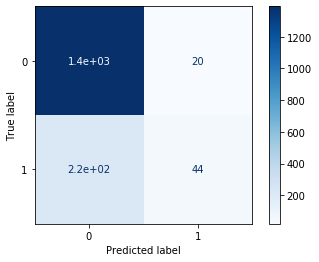

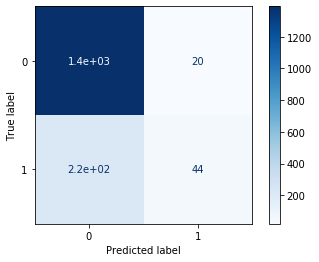

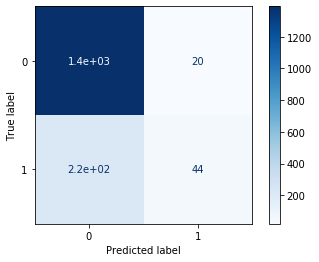

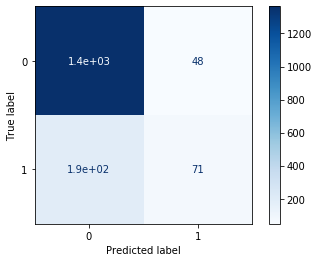

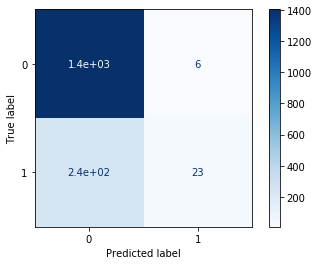

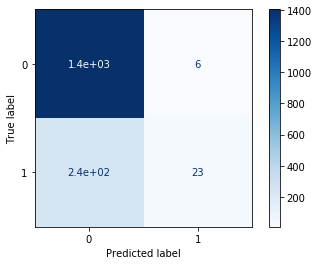

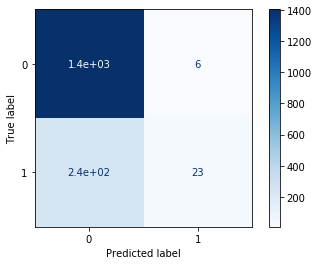

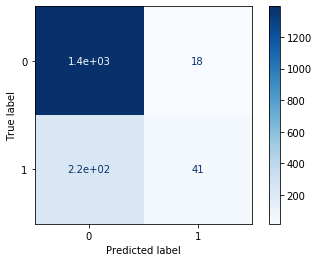

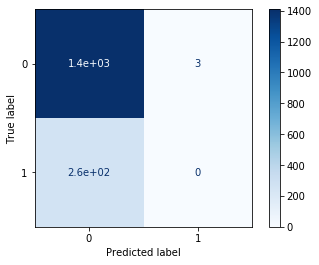

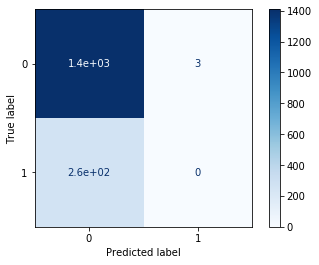

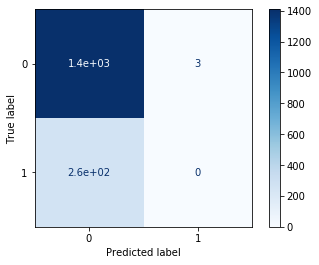

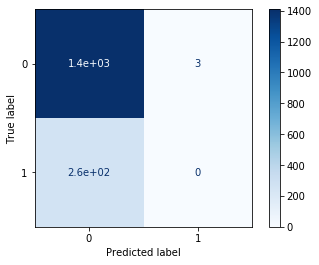

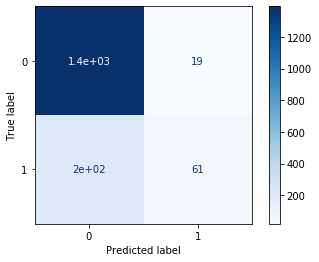

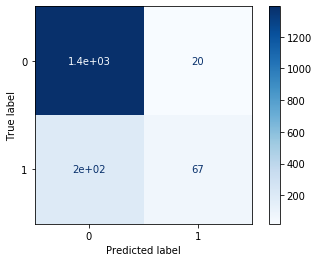

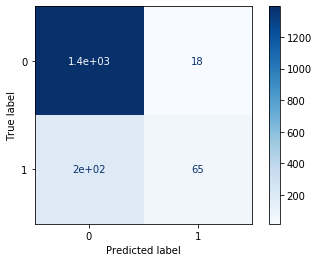

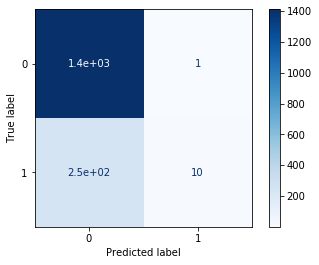

In [51]:
# classification results
idx = -1
all_results = []

for model_name in models_names_cls.values():
    for dataset_name, dataset in zip(datasets_names.values(), datasets):
        idx += 1
        all_results.append(train_cls_model(dataset, labels, best_cls[idx], show_results=True, name= model_name + ', ' + dataset_name))

In [52]:
x = PrettyTable(["Model", "ACC", "F1"])

for i, model in enumerate(best_cls):
    
    x.add_row([type(model).__name__ + ' ' + datasets_names[i%4], round(all_results[i][0], 4),
               round(all_results[i][1], 4)])
print(x)

+-------------------------------------------+--------+--------+
|                   Model                   |  ACC   |   F1   |
+-------------------------------------------+--------+--------+
|             LinearSVC Initial             | 0.8568 | 0.2683 |
|        LinearSVC Forward Selection        | 0.8568 | 0.2683 |
|        LinearSVC Backward Selection       | 0.8568 | 0.2683 |
|               LinearSVC PCA               | 0.8562 | 0.3708 |
|          RidgeClassifier Initial          | 0.8526 | 0.157  |
|     RidgeClassifier Forward Selection     | 0.8526 | 0.157  |
|     RidgeClassifier Backward Selection    | 0.8526 | 0.157  |
|            RidgeClassifier PCA            | 0.8562 | 0.2539 |
|        KNeighborsClassifier Initial       | 0.8407 |  0.0   |
|   KNeighborsClassifier Forward Selection  | 0.8407 |  0.0   |
|  KNeighborsClassifier Backward Selection  | 0.8407 |  0.0   |
|          KNeighborsClassifier PCA         | 0.8407 |  0.0   |
|       RandomForestClassifier Initial  

In [53]:
# regression results
idx = -1
all_results_reg = []

for model_name in models_names_reg.values():
    for dataset_name, dataset in zip(datasets_names.values(), datasets):
        idx += 1
        all_results_reg.append(train_reg_model(dataset, labels, best_reg[idx], show_results=True, name= model_name + ', ' + dataset_name))

For model Ridge Regression, Initial dataset we got the following results:
MAE: 0.2368232266228858
MSE: 0.10609859429676842
R2-score: 0.20049895641965154
RMSE: 0.32572779171690036
For model Ridge Regression, Forward Selection dataset we got the following results:
MAE: 0.2368232266228858
MSE: 0.10609859429676842
R2-score: 0.20049895641965154
RMSE: 0.32572779171690036
For model Ridge Regression, Backward Selection dataset we got the following results:
MAE: 0.23681210199914207
MSE: 0.10610154870762939
R2-score: 0.20047669359343623
RMSE: 0.3257323267771091
For model Ridge Regression, PCA dataset we got the following results:
MAE: 0.23967691411322226
MSE: 0.10512069832493935
R2-score: 0.20786784622608478
RMSE: 0.32422322298832845
For model Linear Regression, Initial dataset we got the following results:
MAE: 0.240308184859978
MSE: 0.10538315548620057
R2-score: 0.20589011244257627
RMSE: 0.3246277182962055
For model Linear Regression, Forward Selection dataset we got the following results:
MAE

In [54]:
x = PrettyTable(["Model", "MAE", "MSE", "R2-score", "RMSE"])

for i, model in enumerate(best_reg):
    
    x.add_row([type(model).__name__ + ' ' + datasets_names[i%4], 
               round(all_results_reg[i][0], 4),
               round(all_results_reg[i][1], 4), round(all_results_reg[i][2], 4), round(all_results_reg[i][3], 5)])
print(x)

+-------------------------------------+--------+--------+----------+---------+
|                Model                |  MAE   |  MSE   | R2-score |   RMSE  |
+-------------------------------------+--------+--------+----------+---------+
|            Ridge Initial            | 0.2368 | 0.1061 |  0.2005  | 0.32573 |
|       Ridge Forward Selection       | 0.2368 | 0.1061 |  0.2005  | 0.32573 |
|       Ridge Backward Selection      | 0.2368 | 0.1061 |  0.2005  | 0.32573 |
|              Ridge PCA              | 0.2397 | 0.1051 |  0.2079  | 0.32422 |
|       LinearRegression Initial      | 0.2403 | 0.1054 |  0.2059  | 0.32463 |
|  LinearRegression Forward Selection | 0.2403 | 0.1054 |  0.2059  | 0.32463 |
| LinearRegression Backward Selection | 0.2403 | 0.1054 |  0.2059  | 0.32463 |
|         LinearRegression PCA        | 0.2397 | 0.1051 |  0.2079  | 0.32423 |
+-------------------------------------+--------+--------+----------+---------+
